In [0]:
import    os
import    matplotlib.pyplot      as plt
import    cv2                    as cv
import    numpy                  as np
import    tensorflow             as tf

from   sklearn.decomposition     import  PCA
from   tqdm                      import  tqdm

from   sklearn.ensemble          import RandomForestClassifier
from   sklearn.model_selection   import cross_val_score
from   sklearn.model_selection   import KFold
from   sklearn.metrics           import *

In [0]:
pathImgTraining     =      '/content/drive/My Drive/DataSet/training/img/'
pathLblTraining     =      '/content/drive/My Drive/DataSet/training/labels/'
pathImgTest         =      '/content/drive/My Drive/DataSet/test/img/'
pathLblTest         =      '/content/drive/My Drive/DataSet/test/labels/'

In [5]:
imagenesTraining    =   os.listdir(pathImgTraining)
imagenesTest        =   os.listdir(pathImgTest)

print('Imagenes de training:',len(imagenesTraining), '; Imagenes de test:',len(imagenesTest))

Imagenes de training: 9 ; Imagenes de test: 3


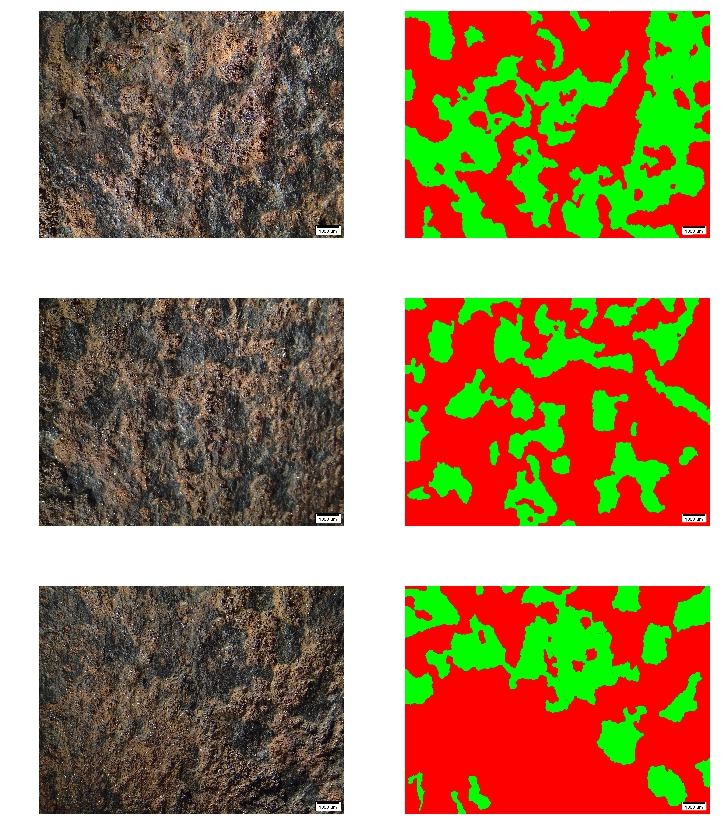

In [13]:
f, axes        =     plt.subplots(3, 2,figsize=(12,15))

for i in range(3):
  
  imagenN = imagenesTraining[i]
  imagen       =     cv.cvtColor(cv.imread(pathImgTraining + imagenN), cv.COLOR_BGR2RGB)
  axes[i,0].axis('off')
  axes[i,0].imshow(imagen) 
  
  label        =     cv.cvtColor(cv.imread(pathLblTraining + imagenN[:-4] + '.png'), cv.COLOR_BGR2RGB)
  axes[i,1].axis('off')
  axes[i,1].imshow(label)

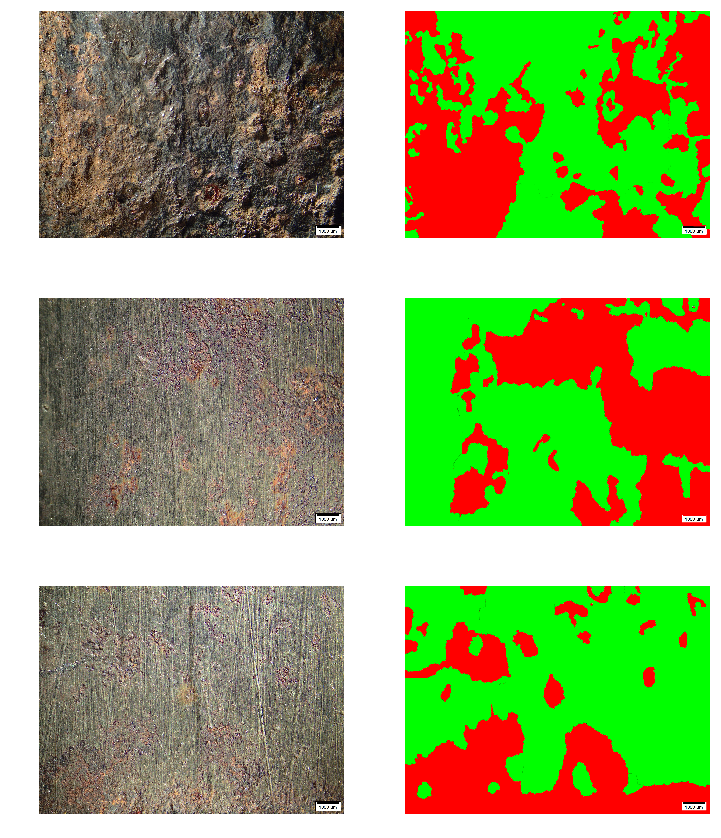

In [14]:
f, axes        =     plt.subplots(3, 2,figsize=(12,15))

for i, imagenN in enumerate(imagenesTest):
  
  imagen       =     cv.cvtColor(cv.imread(pathImgTest + imagenN), cv.COLOR_BGR2RGB)
  axes[i,0].axis('off')
  axes[i,0].imshow(imagen) 
  
  label        =     cv.cvtColor(cv.imread(pathLblTest + imagenN[:-4] + '.png'), cv.COLOR_BGR2RGB)
  axes[i,1].axis('off')
  axes[i,1].imshow(label)

In [0]:
model_VGG16         = tf.keras.applications.VGG16(weights='imagenet')
model_VGG16_conv1   = tf.keras.models.Model(inputs=model_VGG16.input, outputs=model_VGG16.get_layer('block1_conv1').output)
pca                 = PCA(n_components = 64)

In [0]:
def parchar(img, tam, paso):
  
  import numpy as np
  
  parches  = []
  dim      = np.shape(img)
  yInicial = 0
  yFinal   = tam
  totalY   = 0
  
  while yFinal <= dim[0]:
    
    xInicial = 0
    xFinal   = tam  
    totalX   = 0
    
    while xFinal <= dim[1]:
      
      parches.append(img[yInicial:yFinal, xInicial:xFinal])
      #print(xInicial, xFinal, yInicial, yFinal)
      
      xInicial +=  paso
      xFinal   +=  paso
      totalX   += 1
    
    yInicial +=  paso
    yFinal   +=  paso
    totalY   +=  1
      
  return parches, totalY,totalX
  
  

Total de parches: 54
Total de parches: 54
Tamaño del parche: (54, 224, 224, 3)
Dimensiones y, x: 6 9


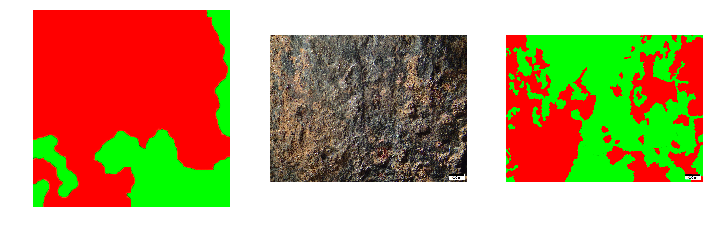

In [0]:
imagenPrueba        = cv.cvtColor(cv.imread(pathImgTest + imagenesTest[0]), cv.COLOR_BGR2RGB)
lblPrueba           = cv.cvtColor(cv.imread(pathLblTest + imagenesTest[0][:-4] + '.png'), cv.COLOR_BGR2RGB) 
parchesPrueba, a, b = parchar(imagenPrueba,224,224)
labelsPrueba, a, b  = parchar(lblPrueba,224,224)

print('Total de parches:', len(parchesPrueba))
print('Total de parches:', len(labelsPrueba))
print('Tamaño del parche:', np.shape(parchesPrueba))
print('Dimensiones y, x:',a, b)

plt.figure(figsize=(12,12))

plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(labelsPrueba[0])

plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(imagenPrueba)

plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(lblPrueba)

In [0]:
def partirIdentificar(parche, lbl):
  
  
  indices             = {0:[], 1:[]}
  caracteristicasV    = {0:[], 1:[]}
  deep                = {0:[], 1:[], 2:[], 3:[]}
  array               = np.expand_dims(parche, axis=0)
  caracteristicas     = model_VGG16_conv1.predict(array)
  
  parchesDeParche, a, b = parchar(lbl,112,112)
  
  for i, parch in enumerate(parchesDeParche):
    
    if np.sum(parch[:,:,0] == 255) == 112*112:
      
      indices[0].append(i)
    
    if np.sum(parch[:,:,1] == 255) == 112*112:
      
      indices[1].append(i)
  
  for i in range(64):
    
    parchesDeCaracteristicas, a, b = parchar(caracteristicas[0,:,:,i], 112, 112)
    
    deep[0].append(parchesDeCaracteristicas[0])
    deep[1].append(parchesDeCaracteristicas[1])
    deep[2].append(parchesDeCaracteristicas[2])
    deep[3].append(parchesDeCaracteristicas[3])
  
  clases = indices.keys()
  
  for clase in clases:
    
    utiles = indices[clase]
    
    for i in utiles:
      
      caracteristicasV[clase].append(deep[i]) 
    
    
  return caracteristicasV 
    
    
  
dic = partirIdentificar(parchesPrueba[0], labelsPrueba[0])
print(np.shape(dic[0]))
print(np.shape(dic[1]))

(1, 64, 112, 112)
(0,)


In [0]:
def unirDeepFeatures_V2(deep,tam):
    
    features_v = [deep[i].reshape(tam*tam) for i in range(64)]
    pca.fit(features_v)
    final      = pca.transform(features_v)
    descriptor = np.concatenate(final)
    
    return descriptor
  
def unirDeepFeatures_V1(deep,tam):
    
    features_v = [deep[0,:,:,i].reshape(tam*tam) for i in range(64)]
    pca.fit(features_v)
    final      = pca.transform(features_v)
    descriptor = np.concatenate(final)
    
    return descriptor

In [0]:
xTrain = []
yTrain = []


for imagenN in imagenesTraining:
  
  
  imagen   = cv.cvtColor(cv.imread(pathImgTraining + imagenN), cv.COLOR_BGR2RGB)
  labels   = cv.cvtColor(cv.imread(pathLblTraining + imagenN[:-4] + '.png'), cv.COLOR_BGR2RGB)
  
  parchesImagen, a, b = parchar(imagen, 224, 224)
  parchesLabels, a, b = parchar(labels, 224, 224)
  
  
  for i in tqdm(range(len(parchesImagen))):
    
    parche = parchesImagen[i]
    label  = parchesLabels[i]
    
    dic = partirIdentificar(parche, label)
    clases = dic.keys()
    
    for clase in clases:
      
      caracteristicas = dic[clase]
      
      for i in range(len(caracteristicas)):
        
        des = unirDeepFeatures_V2(caracteristicas[i],112)
        xTrain.append(des)
        yTrain.append(clase)
    
print(np.shape(xTrain), np.shape(yTrain))    

100%|██████████| 54/54 [00:08<00:00,  3.29it/s]

(671, 4096) (671,)


In [0]:
xTest = []
yTest = []


for imagenN in imagenesTest:
  
  
  imagen   = cv.cvtColor(cv.imread(pathImgTest + imagenN), cv.COLOR_BGR2RGB)
  labels   = cv.cvtColor(cv.imread(pathLblTest + imagenN[:-4] + '.png'), cv.COLOR_BGR2RGB)
  
  parchesImagen, a, b = parchar(imagen, 224, 224)
  parchesLabels, a, b = parchar(labels, 224, 224)
  
  
  for i in tqdm(range(len(parchesImagen))):
    
    parche = parchesImagen[i]
    label  = parchesLabels[i]
    
    dic = partirIdentificar(parche, label)
    clases = dic.keys()
    
    for clase in clases:
      
      caracteristicas = dic[clase]
      
      for i in range(len(caracteristicas)):
        
        des = unirDeepFeatures_V2(caracteristicas[i],112)
        xTest.append(des)
        yTest.append(clase)
    
print(np.shape(xTest), np.shape(yTest))    

100%|██████████| 54/54 [00:14<00:00,  4.00it/s]

(266, 4096) (266,)


In [0]:
def show_curve(est, X, y):
    means, stds = [], []
    nfolds_range = range(2,11)
    for nfolds in nfolds_range:
        #print(nfolds)
        s = cross_val_score(est, X, y, cv=KFold(nfolds, shuffle=True), scoring=make_scorer(accuracy_score))
        means.append(np.mean(s))
        stds.append(np.std(s))

    means = np.r_[means]
    stds  = np.r_[stds]
    
    plt.figure(figsize=(8,5))
    plt.plot(nfolds_range, means, label="mean", color="black")
    plt.fill_between(nfolds_range, means-stds, means+stds, color="blue", alpha=.5, label="std")
    plt.xlabel("n folds")
    plt.ylabel("performance")
    plt.legend()

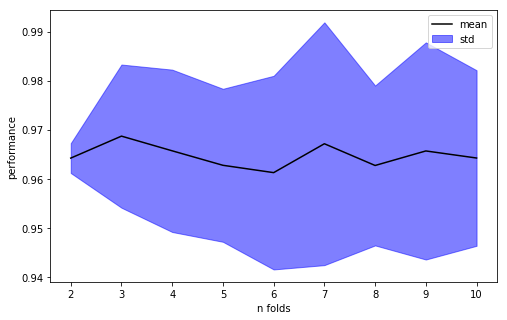

In [0]:
modelo = RandomForestClassifier(criterion = 'entropy', max_depth = 73, n_estimators = 70)
show_curve(modelo, xTrain, yTrain)

In [0]:
modelo.fit(xTrain,yTrain)
print('Test:',modelo.score(xTest,yTest))

Test: 0.9360902255639098


In [0]:
def reconstruir(img, modelo, muestreo):
  
  parches, totalY, totalX  =  parchar(img, 224, muestreo)
  datos                    =  []
  mapa                     =  np.zeros((totalY, totalX, 3)) 
  indice                   =  0
  
  for i in tqdm(range(len(parches))):
    
    array          = np.expand_dims(parches[i], axis=0)
    features_conv1 = model_VGG16_conv1.predict(array)
    
    datos.append(unirDeepFeatures_V1(features_conv1, 224))
  
  clases = modelo.predict(datos)
  
  for y in range(totalY):
    
    for x in range(totalX):
      
      if clases[indice] == 0:
        
        mapa[y,x] = [255,0,0]
      
      else:
        
        mapa[y,x] = [0,255,0]
        
      indice += 1
      
  return mapa
  

In [0]:
mapa = reconstruir(imagenPrueba, modelo, 10)

100%|██████████| 23973/23973 [4:12:13<00:00,  1.75it/s]


W0730 17:50:33.282433 140575254153088 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


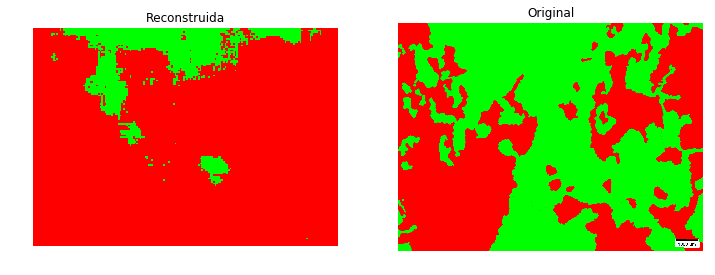

In [0]:
plt.figure(figsize=(12,12))

plt.subplot(1,2,1)
plt.axis('off') 
plt.title('Reconstruida')
plt.imshow(mapa)

plt.subplot(1,2,2)
plt.axis('off') 
plt.title('Original')
plt.imshow(lblPrueba)